# Vocabulary Analysis

Man Ho Wong | April 12, 2022

*Jupyter notebooks are not always rendered properly on Github. Please [view this notebook here on nbviewer](https://nbviewer.org/github/Data-Science-for-Linguists-2022/Child-Vocab-Development/blob/main/code/exploratory_analysis.ipynb) if that happens.*

# 1 Overview

> **Data processing and analysis:**  
>`data_curation.ipynb`  
>`data_preprocessing.ipynb`  
>`exploratory_analysis.ipynb`  
>`vocabulary_analysis.ipynb`  <-- You are here

## 1.1 Objectives


### Table of contents

1. Overview
    - 1.1 Objectives
    - 1.2 Quick recap
    - 1.3 Efficiency considerations

2. Semantic network: vocabulary analysis beyond mean length of utterance (MLU)
    - 2.1 Child vocabulary as a lexical semantic network
    - 2.2 Different metrics for word-to-word similarity
    - 2.3 Constructing lexical semantic network

3. Semantic network analysis
    - 3.1 Characterizing semantic network
    - 3.2 Comparing children from different SES groups

### Script header

In [ ]:
# Python libraries and packages required
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import pprint                    # For pretty printing
import pylangacq                 # For reading CHAT files
import nltk
from gensim.models.keyedvectors import KeyedVectors
import networkx as nx

# For showing progress bar
#   This is useful for estimating the efficiency of the code. You can disable it
#   by remove tqdm() in the code.
from tqdm import tqdm

# Unpickle data
data_idx = pickle.load(open('../data/childes/data_idx_processed.pkl', 'rb'))

# Pretty printing for better readability
# With this, you can print dict in compact format instead of one item
#   per line. Items will be in alphabetical order. Nested Dict will be printed 
#   with suitable indentation. It will also print Counter in descending order.
#   To use this, call cp.pprint()
cp = pprint.PrettyPrinter(compact=True, sort_dicts=True)

# Function to get all labels of a given variable (e.g. 'mot_edu')
def get_labels(var):
    labels_by_corpus = {}
    corpus_set = set(data_idx.corpus)
    for c in corpus_set:
        labels_by_corpus[c] = set(data_idx[var][data_idx.corpus==c])
    return labels_by_corpus

data_idx.head()

,file_path,corpus,year,participants,name,child_id,age_d,age_m,sex,group,ses,mot_edu,situation,activities,study_type
0,../data/childes/Bates/Free20/amy.cha,Bates,NaN,"{CHI, MOT}",Target_Child,Bates_Target_Child,600,20.0,female,TD,MC,unspecified,unspecified,unspecified,"cross, toyplay, TD"
1,../data/childes/Bates/Free20/betty.cha,Bates,NaN,"{CHI, MOT}",Betty,Bates_Betty,600,20.0,female,TD,MC,unspecified,unspecified,unspecified,"cross, toyplay, TD"
2,../data/childes/Bates/Free20/chuck.cha,Bates,NaN,"{CHI, MOT}",Chuck,Bates_Chuck,600,20.0,male,TD,MC,unspecified,unspecified,unspecified,"cross, toyplay, TD"
3,../data/childes/Bates/Free20/doug.cha,Bates,NaN,"{CHI, MOT}",Doug,Bates_Doug,600,20.0,male,TD,MC,unspecified,unspecified,unspecified,"cross, toyplay, TD"
4,../data/childes/Bates/Free20/ed.cha,Bates,NaN,"{CHI, MOT}",Ed,Bates_Ed,600,20.0,male,TD,MC,unspecified,unspecified,unspecified,"cross, toyplay, TD"


In [2]:
ses_list = ['UC', 'MC', 'WC']
paths_ses = {}
readers_ses = {}

# read CHAT files into separate readers according to SES 
print('Reading CHAT files...')
for s in ses_list:
    paths_ses[s] = data_idx[(data_idx.ses == s) & 
                        (data_idx.age_m>=20) & 
                        (data_idx.age_m<=42)].file_path
    readers_ses[s] = pylangacq.Reader.from_files(paths_ses[s])

print('Done!')

Reading CHAT files...
Done!


---

# 2 Semantic network: vocabulary analysis beyond mean length of utterance (MLU)


## 2.1 Child vocabulary as a lexical semantic network

## 2.2 Different metrics for word-to-word similarity

Relationship between words in a lexicon can be represented by how similar they are in their semantic meanings. There are many metrics to measure word-to-word similarity. In general, these metrics can be derived from two different sources: human-annotated datasets (e.g. WordNet), or word associations learned by machine algorithms (e.g. word2vec). Both sources have their pros and cons for different applications. In this project, I will use machine-generated word associations for the calculation of word-to-word similarity because it is more flexible (e.g. getting different word associations by using different training data) than human-annotated datasets and is probably less prone to human biases (depending on training data). Besides, human-annotated datasets are based on formal taxonomies of words and such knowledge is unlikely to be present in a young child's world.

There are two main types of machine-learning models to generate word associations, count-based and prediction-based models. In this project, I will get my word similarity from a semantic network called **ConceptNet**, which is built by both count-based and prediction-based models. The most unique feature about ConceptNet is that, unlike other semantic network, it is concept-based rather than word-based (though nodes are still represented by words or phrases). For mapping word relations in a young child's lexicon where word meanings are more related to the concepts that they are acquiring at the same time, this feature probably makes ConceptNet more suitable than word embeddings derived from other models for this project.

#### 2.3 Constructing lexical semantic network

In this section, I will develop a pipeline for constructing lexical semantic network from each participant's word list in each CHAT file. Below are the general steps:
1. Get the word list from a CHAT file
2. Import ConceptNet-Numberbatch word vectors
3. Map each word in the word list to its word vector
4. Compute pairwise word similarity (cosine similarity) from word vectors
5. Construct a semantic network using cosine similarities as the weights of edges

### Get the word list from a CHAT file
I will use a file from a working-class child to develop the pipeline. For this step, I created a simple function, `get_vocab`, which allows me to get a set of unique words from a CHAT file with the option to specify word classes. This function can also be accessed from `etc.pittchat` like other custom functions in this project.

In [5]:
from etc.pittchat import get_vocab as get_vocab
vocab = get_vocab(readers_ses['WC'][0], pos='n')
cp.pprint(vocab)

{'baby', 'ball', 'ballie', 'bear', 'bike', 'bobby', 'book', 'chair', 'clock',
 'cut', 'dolly', 'door', 'ear', 'eye', 'eyes', 'floor', 'hair', 'hat', 'kitty',
 'light', 'mommy', 'nose', 'pin', 'ride', 'shoe', 'sink', 'spoon', 'teddybear',
 'teeth', 'there'}


### Import ConceptNet-Numberbatch word vectors

Before further processing, we will need to generate word vectors by training models on text data. Due to time constraints and computing resources, I will not not train my own model to get the word vectors. Instead, I will use a pre-trained dataset, ConceptNet-Numberbatch, to get the word vectors. It can be download from their official GitHub. The following code will use the `gensim` package for processing word vectors.

In [10]:
# Download and extract ConceptNet-Numberbatch to your local drive, and run the
#   following code to import the word vectors

# from gensim.models.keyedvectors import KeyedVectors
# wordvec = KeyedVectors.load_word2vec_format('C:\Users\manho\gensim-data\conceptnet-numberbatch-19.08\numberbatch-en.txt')

# Save the word vectors in gensim's native format for efficiency

# wordvec.save('../data/conceptnet/numberbatch-en.kv')

In [7]:
# load saved word vectors from file
wordvec = KeyedVectors.load('../data/conceptnet/numberbatch-en.kv', mmap='r')

### Map each word in the word list to its word vector

A child may produce "words" that not found in their native language as creating new words are very common among young children. Such words may not be found in ConceptNet and this may generate errors. This is generally referred as an out-of-vocabulary (OOV) problem. To handle these words, I will simply remove them from the list for now, although we probably need to develop a better strategy to handle OOV words later when possible.

In [8]:
# Remove out-of-vocabulary words
vocab = [w for w in vocab if wordvec.has_index_for(w)]

# Map each word to its word vector in wordvec
vocab_wv = wordvec[vocab]

### Compute pairwise word similarity (cosine similarity) from word vectors

I will use Scikit-learn's `pairwise.cosine_similarity` function to compute pairwise cosine similarity.

In [9]:
from sklearn import metrics as skm
vocab_sim = skm.pairwise.cosine_similarity(vocab_wv)

### Construct a semantic network using cosine similarities as the weights of edges
I will use the NetworkX library for semantic network construction and analysis.

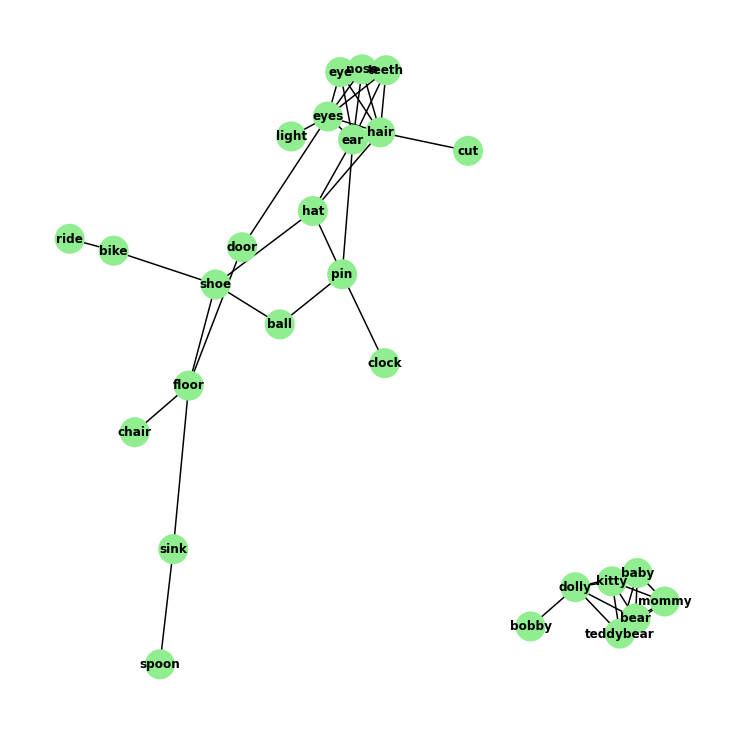

In [11]:
g = nx.Graph()
E = 0.19  # similarity threshold suggested in literature

for a, wordA in enumerate(vocab):
    for b, wordB in enumerate(vocab):
        if wordA != wordB and vocab_sim[a,b] >= E:
            g.add_edge(wordA, wordB, weight=vocab_sim[a,b])
            

options = {
    "node_color": "lightgreen",
    "node_size": 900,
    "edge_color": "black",
    "width": 1.5,
    "edgecolors": "none",
    "font_color": "black",
    "font_weight": "bold",
    "font_size": "12",
}

plt.figure(figsize=(10,10))
pos = nx.spring_layout(g, seed=0)
nx.draw(g, pos, with_labels=True, **options)

---

# 3 Semantic network analysis

## 3.1 Characterizing semantic network

In [13]:
# Number of nodes
g.number_of_nodes()

# Number of edges
g.number_of_edges()

# Average degree
degree_values = [v for k, v in g.degree()]
np.mean(degree_values)

# Average distance
for C in (g.subgraph(c).copy() for c in nx.connected_components(g)):
    nx.average_shortest_path_length(C)
p = dict(nx.shortest_path_length(g))

# Average local clustering coefficient
nx.average_clustering(g)

# all_pairs_node_connectivity
nx.all_pairs_node_connectivity(g)

# connected components
cp.pprint(list(nx.connected_components(g)))
nx.number_connected_components(g)

[{'dolly', 'baby', 'bobby', 'bear', 'teddybear', 'mommy', 'kitty'},
 {'ball', 'bike', 'chair', 'clock', 'cut', 'door', 'ear', 'eye', 'eyes',
  'floor', 'hair', 'hat', 'light', 'nose', 'pin', 'ride', 'shoe', 'sink',
  'spoon', 'teeth'}]


2

In [ ]:
# More metrics

# diameter
# The function computes a lower bound on the diameter
#  (i.e., the maximum eccentricity) of a directed or undirected graph G.
# The procedure used varies depending on the graph being directed or not.
# nx.diameter(g)

# nx.average_degree_connectivity(g)
# nx.degree_centrality(g)

# Small-world-ness
# nx.sigma(g)